<a href="https://colab.research.google.com/github/HuyenNguyenHelen/LING-5412/blob/main/LING5412_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tarfile
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree             # tree.DecisionTreeClassifier()
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm #clf = svm.SVC(decision_function_shape='ovo')
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
# !pip install imbalanced-learn
# import imblearn
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, roc_auc_score

In [13]:
import gensim
import gensim.downloader as api
nlp = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


# Loading data

In [2]:

# Unzip the dataset
#!unzip "/content/dontpatronizeme_v1.3.zip" -d "/content/drive/MyDrive/"

In [3]:
# Opening the file from MyDrive
file = open(r'/content/drive/MyDrive/dontpatronizeme_v1.3/dontpatronizeme_pcl.tsv')
reader = csv.reader(file, delimiter="\t")
data = []
for row in reader:
  data.append(row)


In [4]:
df = pd.DataFrame(data[5:],  columns = ['docID', 'keyword', 'country', 'paragraph', 'label' ] )
df

,docID,keyword,country,paragraph,label
0,@@4703096,immigrant,jm,NBC and Spanish-language Univision both declin...,0
1,@@25567226,in-need,hk,A second T-Home project is being launched in t...,0
2,@@1824078,poor-families,tz,Camfed would like to see this trend reversed ....,4
3,@@1921089,refugee,tz,Kagunga village was reported to lack necessary...,0
4,@@40039380,women,ng,Haruna stressed the need for specific approach...,0
...,...,...,...,...,...
10053,@@16413808,immigrant,my,"To me , I am always mindful that we are dealin...",4
10054,@@8676630,vulnerable,jm,Other themes included promoting the inclusion ...,0
10055,@@7688552,immigrant,gb,It came as the CDU was also humiliated by the ...,0
10056,@@4916290,hopeless,in,"Those were only days of helplessness , she say...",0


# Exploring data

In [5]:
# Length of text
def length (txt):
  length = len(txt.split())
  return length

txt_length = df['paragraph'].apply(lambda x: length(x))
txt_length.sort_values(ascending = False)

3534    1519
6266    1095
8519    1040
4613     772
8819     729
        ... 
1930       4
1385       3
7375       3
5112       3
5742       0
Name: paragraph, Length: 10058, dtype: int64

In [6]:
# Observing labels
df['label'].value_counts()

0    8206
1     906
3     435
4     369
2     142
Name: label, dtype: int64

In [7]:
df['label'] = df['label'].astype(str)
df['label']

0        0
1        0
2        4
3        0
4        0
        ..
10053    4
10054    0
10055    0
10056    0
10057    0
Name: label, Length: 10058, dtype: object

In [8]:
# Missing data
#checking missing values
print('Is null: \n', df.isnull().sum() )


Is null: 
 docID        0
keyword      0
country      0
paragraph    0
label        0
dtype: int64


0    9112
1     946
Name: label, dtype: int64


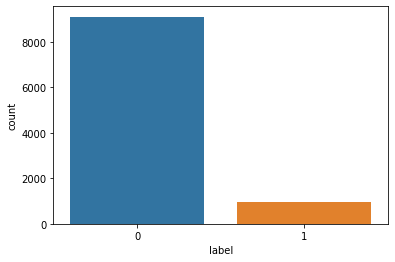

In [9]:
# Turning labels to binary

label_dic = {'0':0,
             '1':0,
             '2':1,
             '3':1,
             '4':1}
df['label'] = df['label'].map(label_dic)
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.show()

# Developing models

In [10]:
# Splitting the data into training (80%) and test set(20%)
from sklearn.model_selection import train_test_split
X = df['paragraph']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split (X, y, train_size = 0.8, random_state = 42, shuffle = True, stratify=y)
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)
print(y_train.value_counts())

Shapes of X_train, y_train:  (8046,) (8046,)
Shapes of X_test, y_test:  (2012,) (2012,)
0    7289
1     757
Name: label, dtype: int64


## Classic ML models

### Text representation

In [15]:
!pip install stop-words
from stop_words import get_stop_words
stopwords = get_stop_words('en')
from textblob import Word
import re
import nltk
nltk.download('wordnet')

#BOW based approaches
nlp.init_sims(replace=True) # calling for using syn0norm

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=a02bf58ce43c3b3f07cb1420028ca71f81dd505cac6290600f2aae58d6b1e7a4
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [19]:
# Tokenize, and apply word vector averaging to tokenized text
import nltk
nltk.download('punkt')
import logging
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    

X_train_tokenized = X_train.apply(lambda x: w2v_tokenize_text(x)).values
X_test_tokenized = X_test.apply(lambda x: w2v_tokenize_text(x)).values

X_train_word_average = word_averaging_list(nlp,X_train_tokenized)
X_test_word_average = word_averaging_list(nlp,X_test_tokenized)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).


### Creating models

In [20]:
# Printing model performance 
def printing_eval_scores (y_true, y_pred):
  print('accuracy score: {}'.format(sklearn.metrics.accuracy_score(y_true, y_pred)))
  print('precision score: {}'.format(sklearn.metrics.precision_score(y_true, y_pred, average = 'weighted', zero_division=1)))
  print('recall score: {}'.format(sklearn.metrics.recall_score(y_true, y_pred,  average = 'weighted', zero_division=1)))
  print('F1 score: {}'.format(sklearn.metrics.f1_score(y_true, y_pred,  average = 'weighted', zero_division=1)))
  print(classification_report(y_true, y_pred))

In [21]:
# Define a function for creating over sampling 
def score_model(model):
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)

    oversampler = SMOTE(random_state=42)
    #oversampler = RandomOverSampler(sampling_strategy='minority')
    scores = []

    ## on training set, do cv
    for train_fold_index, val_fold_index in cv.split(X_train_word_average, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train_word_average[train_fold_index], y_train.iloc[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train_word_average[val_fold_index], y_train.iloc[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = oversampler.fit_resample(X_train_fold,
                                                                           y_train_fold)
        # Fit the model on the upsampled training data
        model.fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = accuracy_score(y_val_fold, model.predict(X_val_fold)) #  average= 'weighted' for F1
        scores.append(score)
    print('Average of acuracy score in training: %s' % np.array(scores).mean())

    ## on test set
    y_pred = model.predict(X_test_word_average)
    test_score = accuracy_score( y_test,y_pred)
    printing_eval_scores (y_test, y_pred)
    report_scores = {'accuracy_folds':np.array(scores),'accuracy_test':test_score, 'y_predicted':y_pred }
    return report_scores #(np.array(scores),test_score,y_pred )       #(np.array(scores).mean(), np.array(scores).std())

In [22]:
# Running all models together
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=700)))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(decision_function_shape='ovo', probability=True)))
# evaluate each model in turn
results = []
score_test = []
names = []
report_scores_all = []
for name, model in models:
  #fold_scores, test_score = score_model(model)
  report_scores = score_model(model)
  report_scores_all.append(report_scores)
  #results.append(fold_scores)
  #score_test.append(test_score)
  results.append(report_scores['accuracy_folds'])
  score_test.append(report_scores['accuracy_test'])
  names.append(name)
  # msg = "%s: %f (%f)" % (name, fold_scores.mean(), fold_scores.std())
  msg = "%s: %f (%f)" % (name, report_scores['accuracy_folds'].mean(), report_scores['accuracy_folds'].std())
  print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

NameError: ignored